In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import numpy.random as rnd
import random
import gym_minigrid
import gym_minigrid.envs
import pickle

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

In [3]:
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'mountaincar': gym.make('MountainCar-v0'),
    'acrobot': gym.make('Acrobot-v1'),
    'lunarlander': gym.make('LunarLander-v2'),
    'unlockminigrid': gym_minigrid.envs.Unlock(),
    'unlockpickup': gym_minigrid.envs.UnlockPickup(),
    'blockedunlockpickup': gym_minigrid.envs.BlockedUnlockPickup(),
    'fourrooms': gym_minigrid.envs.FourRoomsEnv()
}

In [4]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(state):
            return env.action_space.sample()

    state = env.reset()
    env.render()

    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        env.render()

        if done:
            break

    env.close()

In [5]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)

    for b in buttons:
        b.disabled = False


buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [6]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [7]:
print(torch.cuda.is_available())

True


In [8]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = math.log(self.value_to/self.value_from)/(num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if(step < 0):
            return self.value_from
        elif(step >= self.num_steps):
            return self.value_to
        value = self.a * math.exp(self.b * step)
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )


_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

In [9]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # YOUR CODE HERE:  store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        
        sample_indices = random.sample(range(1,self.size),min(self.size,batch_size))
        states = torch.empty((len(sample_indices),self.state_size))
        actions = torch.empty((len(sample_indices)))
        rewards = torch.empty((len(sample_indices)))
        next_states = torch.empty((len(sample_indices),self.state_size))
        dones = torch.empty((len(sample_indices)))
        i = 0
        
        
        for idx in sample_indices:
            states[i]= self.states[idx]
            actions[i] = self.actions[idx]
            rewards[i] = self.rewards[idx]
            next_states[i] = self.next_states[idx]
            dones[i] = self.dones[idx]
            i+=1

        batch = Batch(states = states, actions = actions, rewards = rewards, next_states = next_states, dones = dones)

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # YOUR CODE HERE:  run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint:  don't repeat code!  Use the self.add() method!
        state = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = env.reset()            

In [10]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()

        # YOUR CODE HERE:  define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.learning_rate = 0.001
        
        self.input_layer = nn.Linear(state_dim,hidden_dim)
#         self.layers = [input_layer]
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers-2):
            self.hidden_layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.output_layer = nn.Linear(hidden_dim,action_dim)
        

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # YOUR CODE HERE:  use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        x = torch.Tensor(states)
        x = F.relu(self.input_layer(x))
        for i in self.hidden_layers:
            x = F.relu(i(x))
        return self.output_layer(x)
        

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# test code, do not edit


def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad: 
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )


dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

In [11]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [12]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        # FEEDBACK: inefficient;  you're computing Q_array before knowing whether you need it.
        Q_array = dqn_model.forward(state)
        eps = exploration.value(t_total)
        
        if rnd.rand() < eps:
            num_actions = Q_array.shape[0]
            action = rnd.randint(num_actions)
        else:
            # FEEDBACK: don't need to find all maximal actions;  it is virtually impossible for two actions to have
            # the same value.
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
            
        next_state, reward, done, _ = env.step(action)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        
        rewards.append(reward)
        
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
            
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            t_episode = 0
            state = env.reset()
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [391]:
env = envs['lunarlander']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:70: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [415]:
filehandler = open("pickle/lunarlander_dqn_returns.pkl", 'wb') 
pickle.dump(returns, filehandler)
filehandler.close()

filehandler2 = open("pickle/lunarlander_dqn_losses.pkl", 'wb') 
pickle.dump(losses, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/lunarlander_dqn_lengths.pkl", 'wb') 
pickle.dump(lengths, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Cartpole Environment')

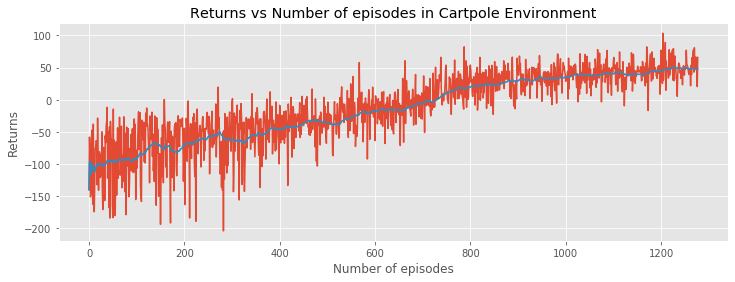

In [397]:
### YOUR PLOTTING CODE HERE
plt.plot(returns)
plt.plot(rolling_average(returns,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Cartpole Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Cartpole Environment')

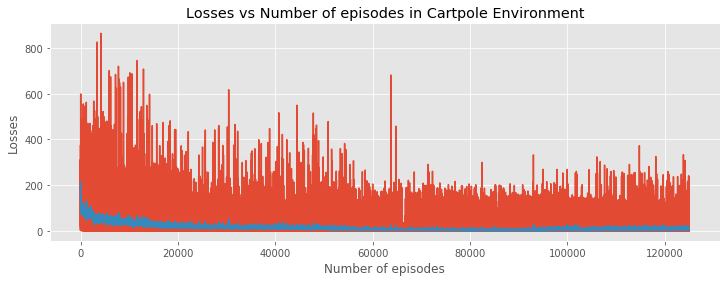

In [398]:
### YOUR PLOTTING CODE HERE
plt.plot(losses)
plt.plot(rolling_average(losses,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Cartpole Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Cartpole Environment')

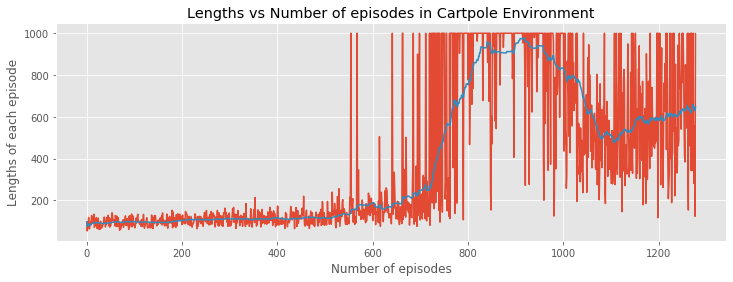

In [399]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths)
plt.plot(rolling_average(lengths,window_size=50))
plt.ylabel("Lengths of each episode")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Cartpole Environment")

In [381]:
PBatch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'indices', 'priorities', 'weights')
)


class PrioritizedReplayMemory:
    def __init__(self, max_size, state_size, alpha, beta, batch_size):
        self.max_size = max_size
        self.state_size = state_size
        self.alpha = alpha
        self.beta = beta

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))
        self.indices = torch.empty((max_size, 1))
        self.priorities = torch.zeros(max_size,dtype=torch.long)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0
        
        self.states_buffer = torch.empty((batch_size,self.state_size))
        self.actions_buffer = torch.empty((batch_size))
        self.rewards_buffer = torch.empty((batch_size))
        self.next_states_buffer = torch.empty((batch_size,self.state_size))
        self.dones_buffer = torch.empty((batch_size))
        self.indices_buffer = torch.empty((batch_size))
        self.priorities_buffer = torch.zeros(batch_size)

    def add(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        self.indices[self.idx][0] = torch.tensor(self.idx)
        max_priority = self.priorities.max(0)
        if(len(max_priority) == 0):
            self.priorities[self.idx] = torch.tensor(1)
        else:
            self.priorities[self.idx] = torch.tensor(max_priority[0])
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> PBatch:
        size = min(batch_size,self.size)
        sample_indices = random.sample(range(1,self.size),size)
        i = 0
        
        
        for idx in sample_indices:
            self.states_buffer[i]= self.states[idx]
            self.actions_buffer[i] = self.actions[idx]
            self.rewards_buffer[i] = self.rewards[idx]
            self.next_states_buffer[i] = self.next_states[idx]
            self.dones_buffer[i] = self.dones[idx]
            self.indices_buffer[i] = self.indices[idx]
            self.priorities_buffer[i] = math.pow(self.priorities[idx],self.alpha) + 0.01
            i+=1
            
        priorities = self.priorities_buffer.mul(size)
        weights = torch.pow(priorities, -self.beta)
        weights = weights.div(weights.max())

        batch = PBatch(states = self.states_buffer, actions = self.actions_buffer, 
                       rewards = self.rewards_buffer, next_states = self.next_states_buffer, dones = self.dones_buffer,
                       indices = self.indices_buffer, priorities = priorities, weights = weights)

        return batch

    def populate(self, env, num_steps):
        state = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            next_state = next_state
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = env.reset()
                
    def update(self, indices, priorities):
        count = 0
        for i in indices:
            self.priorities[i.long()] = priorities[count]
            count += 1

In [382]:
def train_dqn_batch_prioritized(optimizer, memory, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    
    errors = torch.abs(target_values - values)    
    memory.update(batch.indices, errors)
    
    loss = (torch.FloatTensor(batch.weights) * F.mse_loss(values, target_values)).mean()

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [383]:
def train_dqn_prioritized(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    alpha,
    beta
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = PrioritizedReplayMemory(replay_size, state_size, alpha, beta, batch_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        Q_array = dqn_model.forward(state)
        eps = exploration.value(t_total)
        
        if rnd.rand() < eps:
            num_actions = Q_array.shape[0]
            action = rnd.randint(num_actions)
        else:
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
            
        next_state, reward, done, _ = env.step(action)
        next_state = next_state
        memory.add(state, action, reward, next_state, done)
        state = next_state
        
        rewards.append(reward)
        
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch_prioritized(optimizer, memory, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
            
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            t_episode = 0
            state = env.reset()
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [384]:
env = envs['lunarlander']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns_per, lengths_per, losses_per = train_dqn_prioritized(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [387]:
filehandler = open("pickle/lunarlander_dqn_per_returns.pkl", 'wb') 
pickle.dump(returns_per, filehandler)
filehandler.close()

filehandler2 = open("pickle/lunarlander_dqn_per_losses.pkl", 'wb') 
pickle.dump(losses_per, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/lunarlander_dqn_per_lengths.pkl", 'wb') 
pickle.dump(lengths_per, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Cartpole Environment')

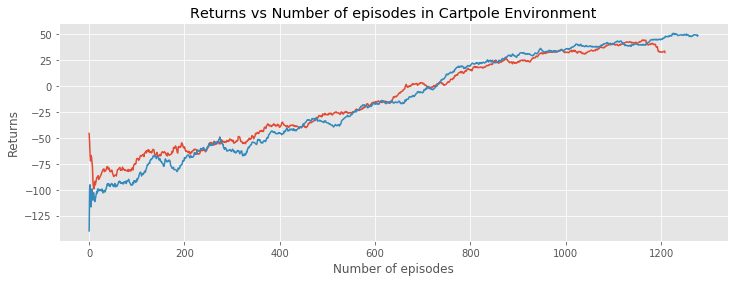

In [400]:
### YOUR PLOTTING CODE HERE
# plt.plot(returns_per)
plt.plot(rolling_average(returns_per,window_size=50))
# plt.plot(returns)
plt.plot(rolling_average(returns,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Cartpole Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Cartpole Environment')

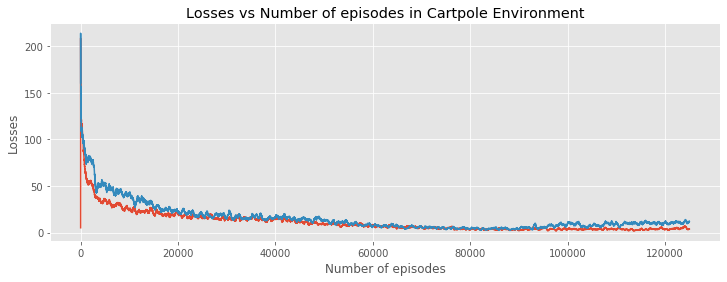

In [401]:
### YOUR PLOTTING CODE HERE
plt.plot(rolling_average(losses_per,window_size=500))
plt.plot(rolling_average(losses,window_size=500))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Cartpole Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Cartpole Environment')

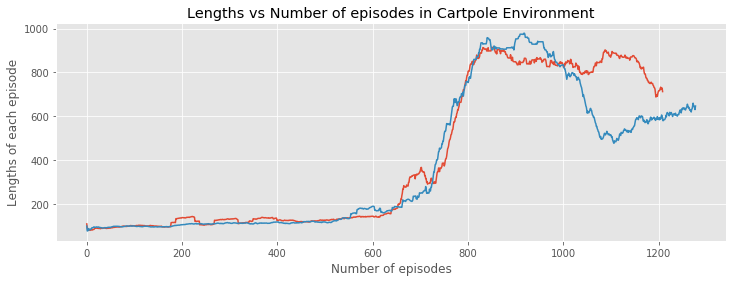

In [402]:
### YOUR PLOTTING CODE HERE
plt.plot(rolling_average(lengths_per,window_size=50))
plt.plot(rolling_average(lengths,window_size=50))
plt.ylabel("Lengths of each episode")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Cartpole Environment")

In [275]:
# Batch namedtuple, i.e. a class which contains the given attributes
MBatch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)

def flatten_image(state):
    temp = state["image"].flatten()
    temp = np.append(temp,state["direction"])
    temp = np.append(temp,sum([ord(c) for c in state["mission"]]))
    return torch.Tensor(temp)

class ReplayMemoryMinigrid:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # YOUR CODE HERE:  store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.
        
        sample_indices = random.sample(range(1,self.size),min(self.size,batch_size))
        
        states = torch.empty((len(sample_indices),self.state_size))
        actions = torch.empty((len(sample_indices)))
        rewards = torch.empty((len(sample_indices)))
        next_states = torch.empty((len(sample_indices),self.state_size))
        dones = torch.empty((len(sample_indices)))
        i = 0
        
        
        for idx in sample_indices:
            states[i]= self.states[idx]
            actions[i] = self.actions[idx]
            rewards[i] = self.rewards[idx]
            next_states[i] = self.next_states[idx]
            dones[i] = self.dones[idx]
            i+=1

        batch = Batch(states = states, actions = actions, rewards = rewards, next_states = next_states, dones = dones)

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # YOUR CODE HERE:  run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint:  don't repeat code!  Use the self.add() method!
        state = flatten_image(env.reset())
        pbar = tqdm.trange(num_steps)
        for i in pbar:
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            next_state = flatten_image(next_state)
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = flatten_image(env.reset())   

In [276]:
class DQNMinigrid(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()

        # YOUR CODE HERE:  define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.learning_rate = 0.001
        
        self.input_layer = nn.Linear(state_dim,hidden_dim)
#         self.layers = [input_layer]
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers-2):
            self.hidden_layers.append(nn.Linear(hidden_dim,hidden_dim))
        self.output_layer = nn.Linear(hidden_dim,action_dim)
        

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        # YOUR CODE HERE:  use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        x = torch.Tensor(states)
        x = F.relu(self.input_layer(x))
        for i in self.hidden_layers:
            x = F.relu(i(x))
        return self.output_layer(x)
        

    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }



In [277]:
def train_dqn_batch_minigrid(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [278]:
def train_dqn_minigrid(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation

    # get the state_size from the environment
    state_size = flatten_image(env.reset()).shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQNMinigrid(state_size, env.action_space.n)
    dqn_target = DQNMinigrid.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = ReplayMemoryMinigrid(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = flatten_image(env.reset())  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        Q_array = dqn_model.forward(state.unsqueeze(0))
        eps = exploration.value(t_total)
        
        if rnd.rand() < eps:
            num_actions = Q_array.shape[1]
            action = rnd.randint(num_actions)
        else:
            # FEEDBACK: don't need to find all maximal actions;  it is virtually impossible for two actions to have
            # the same value.
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
            
        next_state, reward, done, _ = env.step(action)
        next_state = flatten_image(next_state)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        
        rewards.append(reward)
        
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch_minigrid(optimizer, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
            
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            t_episode = 0
            state = flatten_image(env.reset())
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [279]:
env = envs['unlockminigrid']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_minigrid, returns_minigrid, lengths_minigrid, losses_minigrid = train_dqn_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_minigrid.items()}
torch.save(checkpoint, f'checkpoint_unlock.pt')



100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:21<00:00, 2357.02it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:70: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [280]:
print(returns_minigrid)
filehandler = open("pickle/unlock_minigrid_dqn_returns.pkl", 'wb') 
pickle.dump(returns_minigrid, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_minigrid_dqn_losses.pkl", 'wb') 
pickle.dump(losses_minigrid, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_minigrid_dqn_lengths.pkl", 'wb') 
pickle.dump(lengths_minigrid, filehandler3)
filehandler3.close()

[0. 0. 0. ... 0. 0. 0.]


Text(0.5, 1.0, 'Returns vs Number of episodes in Mountain Car Environment')

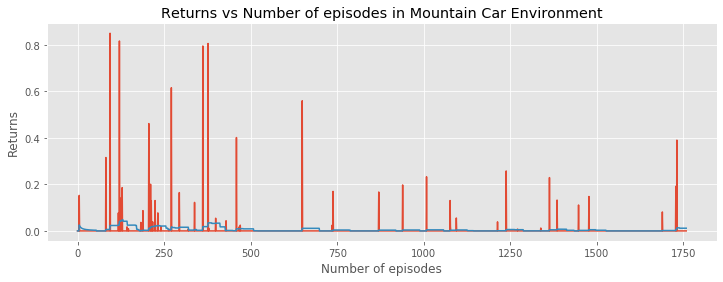

In [281]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_minigrid)
plt.plot(rolling_average(returns_minigrid,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Mountain Car Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Mountain Car Environment')

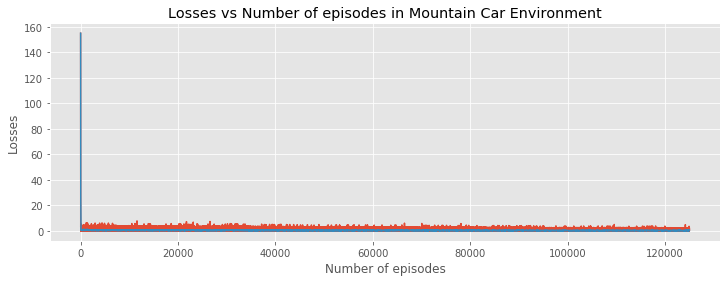

In [282]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_minigrid)
plt.plot(rolling_average(losses_minigrid,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Mountain Car Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Mountain Car Environment')

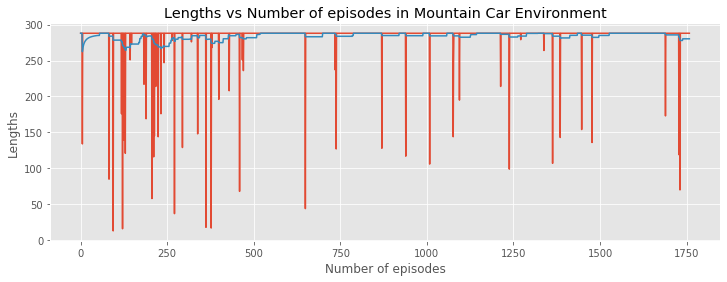

In [283]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_minigrid)
plt.plot(rolling_average(lengths_minigrid,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Mountain Car Environment")

In [284]:
env = envs['unlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 0.8 * num_steps)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_unlock_pickup, returns_unlock_pickup, lengths_unlock_pickup, losses_unlock_pickup = train_dqn_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_unlock_pickup.items()}
torch.save(checkpoint, f'checkpoint_unlockpickup.pt')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:21<00:00, 2300.98it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:70: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [285]:
filehandler = open("pickle/unlock_pickup_minigrid_dqn_returns.pkl", 'wb') 
pickle.dump(returns_unlock_pickup, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_pickup_minigrid_dqn_losses.pkl", 'wb') 
pickle.dump(losses_unlock_pickup, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_pickup_minigrid_dqn_lengths.pkl", 'wb') 
pickle.dump(lengths_unlock_pickup, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Acrobot Environment')

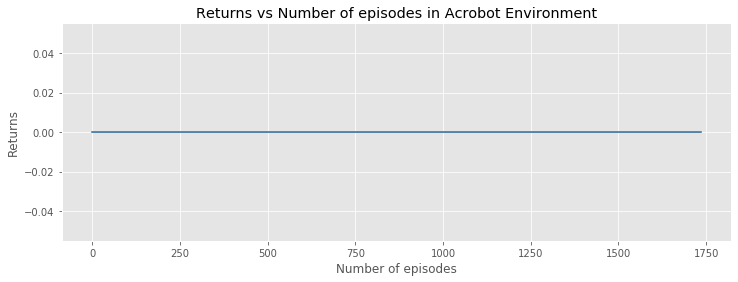

In [286]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_unlock_pickup)
plt.plot(rolling_average(returns_unlock_pickup,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Acrobot Environment')

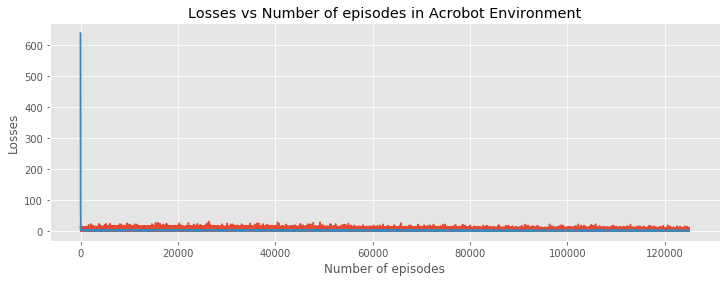

In [287]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_unlock_pickup)
plt.plot(rolling_average(losses_unlock_pickup,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Acrobot Environment')

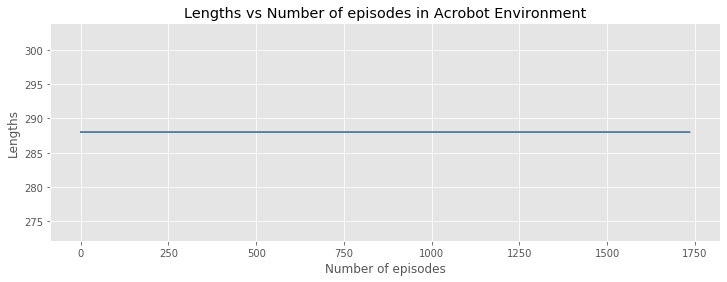

In [288]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_unlock_pickup)
plt.plot(rolling_average(lengths_unlock_pickup,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Acrobot Environment")

In [289]:
env = envs['blockedunlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 0.8 * num_steps)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_blocked_unlock_pickup, returns_blocked_unlock_pickup, lengths_blocked_unlock_pickup, losses_blocked_unlock_pickup = train_dqn_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_blocked_unlock_pickup.items()}
torch.save(checkpoint, f'checkpoint_blockedunlock.pt')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:22<00:00, 2252.70it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:70: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [290]:
filehandler = open("pickle/blocked_unlock_pickup_minigrid_dqn_returns.pkl", 'wb') 
pickle.dump(returns_blocked_unlock_pickup, filehandler)
filehandler.close()

filehandler2 = open("pickle/blocked_unlock_pickup_minigrid_dqn_losses.pkl", 'wb') 
pickle.dump(losses_blocked_unlock_pickup, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/blocked_unlock_pickup_minigrid_dqn_lengths.pkl", 'wb') 
pickle.dump(lengths_blocked_unlock_pickup, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

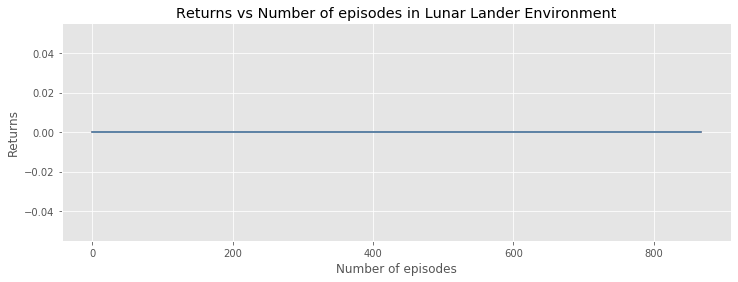

In [291]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_blocked_unlock_pickup)
plt.plot(rolling_average(returns_blocked_unlock_pickup,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

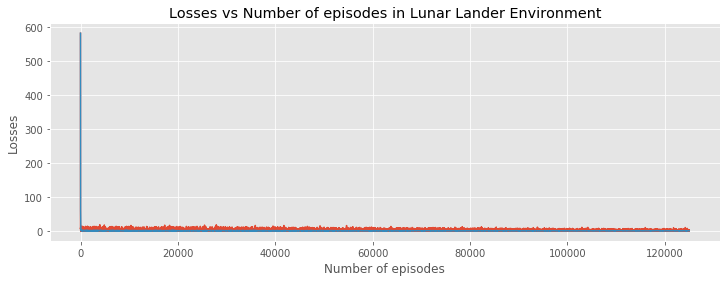

In [292]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_blocked_unlock_pickup)
plt.plot(rolling_average(losses_blocked_unlock_pickup,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

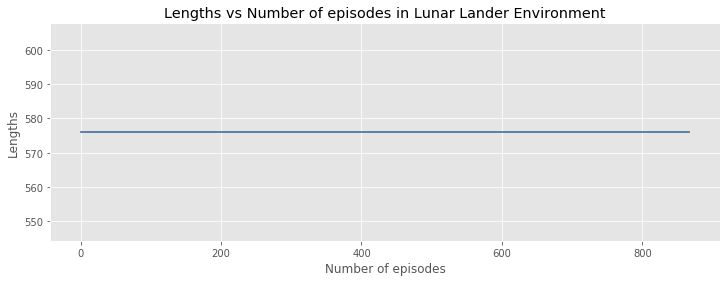

In [293]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_blocked_unlock_pickup)
plt.plot(rolling_average(lengths_blocked_unlock_pickup,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [294]:
env = envs['fourrooms']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 0.8 * num_steps)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_four_rooms, returns_four_rooms, lengths_four_rooms, losses_four_rooms = train_dqn_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_four_rooms.items()}
torch.save(checkpoint, f'checkpoint_fourrooms.pt')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:25<00:00, 1968.42it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:70: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [295]:
filehandler = open("pickle/four_rooms_minigrid_dqn_returns.pkl", 'wb') 
pickle.dump(returns_four_rooms, filehandler)
filehandler.close()

filehandler2 = open("pickle/four_rooms_minigrid_dqn_losses.pkl", 'wb') 
pickle.dump(losses_four_rooms, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/four_rooms_minigrid_dqn_lengths.pkl", 'wb') 
pickle.dump(lengths_four_rooms, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

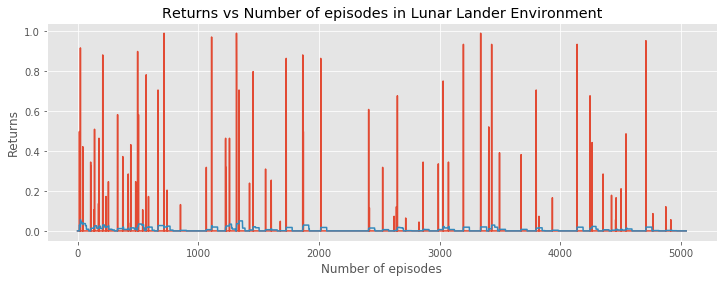

In [296]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_four_rooms)
plt.plot(rolling_average(returns_four_rooms,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

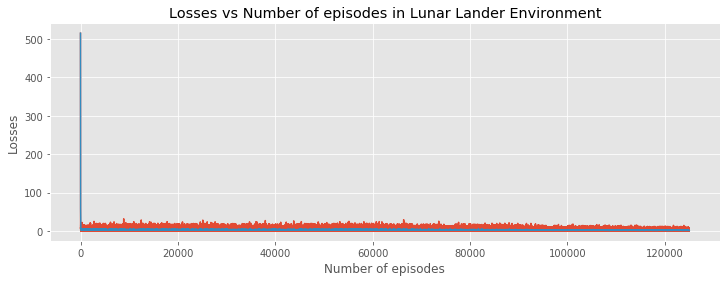

In [297]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_four_rooms)
plt.plot(rolling_average(losses_four_rooms,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

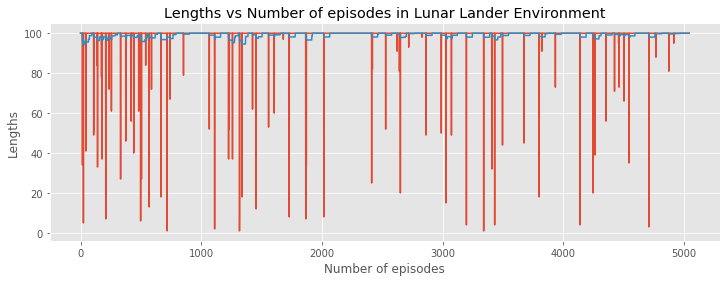

In [298]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_four_rooms)
plt.plot(rolling_average(lengths_four_rooms,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [299]:
PBatch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'indices', 'priorities', 'weights')
)


class PrioritizedReplayMemoryMinigrid:
    def __init__(self, max_size, state_size, alpha, beta, batch_size):
        self.max_size = max_size
        self.state_size = state_size
        self.alpha = alpha
        self.beta = beta

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))
        self.indices = torch.empty((max_size, 1))
        self.priorities = torch.zeros(max_size,dtype=torch.long)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0
        
        self.states_buffer = torch.empty((batch_size,self.state_size))
        self.actions_buffer = torch.empty((batch_size))
        self.rewards_buffer = torch.empty((batch_size))
        self.next_states_buffer = torch.empty((batch_size,self.state_size))
        self.dones_buffer = torch.empty((batch_size))
        self.indices_buffer = torch.empty((batch_size))
        self.priorities_buffer = torch.zeros(batch_size)

    def add(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        self.indices[self.idx][0] = torch.tensor(self.idx)
        max_priority = self.priorities.max(0)
        if(len(max_priority) == 0):
            self.priorities[self.idx] = torch.tensor(1)
        else:
            self.priorities[self.idx] = torch.tensor(max_priority[0])
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> PBatch:
        size = min(batch_size,self.size)
        sample_indices = random.sample(range(1,self.size),size)
        i = 0
        
        
        for idx in sample_indices:
            self.states_buffer[i]= self.states[idx]
            self.actions_buffer[i] = self.actions[idx]
            self.rewards_buffer[i] = self.rewards[idx]
            self.next_states_buffer[i] = self.next_states[idx]
            self.dones_buffer[i] = self.dones[idx]
            self.indices_buffer[i] = self.indices[idx]
            self.priorities_buffer[i] = math.pow(self.priorities[idx],self.alpha) + 0.01
            i+=1
            
        priorities = self.priorities_buffer.mul(size)
        weights = torch.pow(priorities, -self.beta)
        weights = weights.div(weights.max())

        batch = PBatch(states = self.states_buffer, actions = self.actions_buffer, 
                       rewards = self.rewards_buffer, next_states = self.next_states_buffer, dones = self.dones_buffer,
                       indices = self.indices_buffer, priorities = priorities, weights = weights)

        return batch

    def populate(self, env, num_steps):
        state = flatten_image(env.reset())
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            next_state = flatten_image(next_state)
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = flatten_image(env.reset())
                
    def update(self, indices, priorities):
        count = 0
        for i in indices:
            self.priorities[i.long()] = priorities[count]
            count += 1

In [300]:
def train_dqn_batch_prioritized_minigrid(optimizer, memory, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    
    errors = torch.abs(target_values - values)    
    memory.update(batch.indices, errors)
    
    loss = (torch.FloatTensor(batch.weights) * F.mse_loss(values, target_values)).mean()

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [301]:
def train_dqn_prioritized_minigrid(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    alpha,
    beta
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """

    # get the state_size from the environment
    state_size = flatten_image(env.reset()).shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = PrioritizedReplayMemoryMinigrid(replay_size, state_size, alpha, beta, batch_size)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = flatten_image(env.reset())  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        Q_array = dqn_model.forward(state.unsqueeze(0))
        eps = exploration.value(t_total)
        
        if rnd.rand() < eps:
            num_actions = Q_array.shape[1]
            action = rnd.randint(num_actions)
        else:
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
            
        next_state, reward, done, _ = env.step(action)
        next_state = flatten_image(next_state)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        
        rewards.append(reward)
        
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
        
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch_prioritized_minigrid(optimizer, memory, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
        
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
            
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            t_episode = 0
            state = flatten_image(env.reset())
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [302]:
env = envs['unlockminigrid']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_unlock_per, returns_unlock_per, lengths_unlock_per, losses_unlock_per = train_dqn_prioritized_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_unlock_per.items()}
torch.save(checkpoint, f'checkpoint_unlockper.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [303]:
filehandler = open("pickle/unlock_minigrid_dqn_returns_per.pkl", 'wb') 
pickle.dump(returns_unlock_per, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_minigrid_dqn_losses_per.pkl", 'wb') 
pickle.dump(losses_unlock_per, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_minigrid_dqn_lengths_per.pkl", 'wb') 
pickle.dump(lengths_unlock_per, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Acrobot Environment')

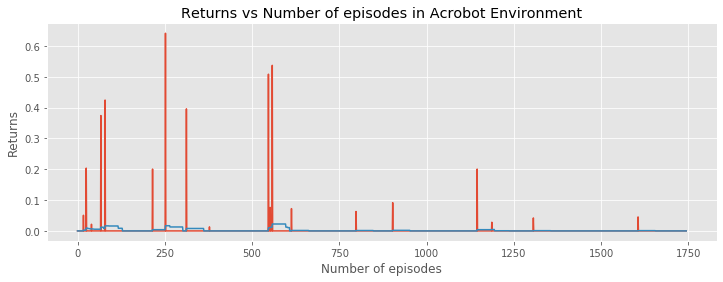

In [304]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_unlock_per)
plt.plot(rolling_average(returns_unlock_per,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Acrobot Environment')

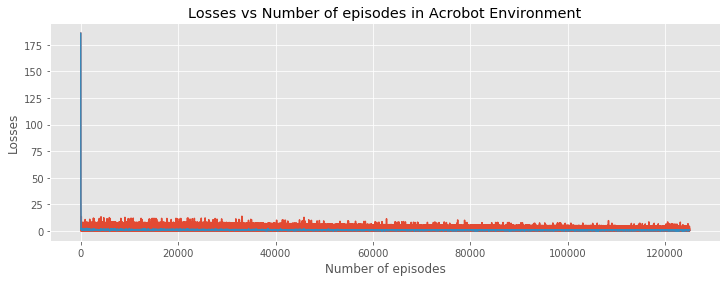

In [305]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_unlock_per)
plt.plot(rolling_average(losses_unlock_per,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Acrobot Environment')

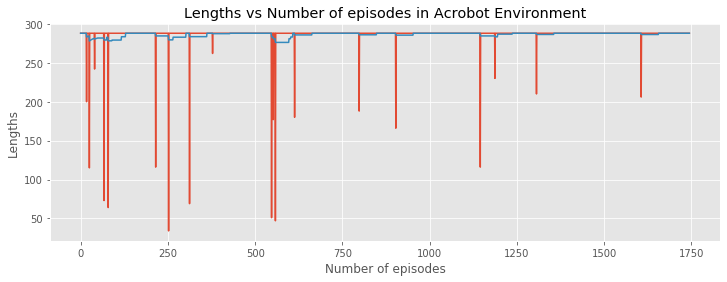

In [306]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_unlock_per)
plt.plot(rolling_average(lengths_unlock_per,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Acrobot Environment")

In [323]:
env = envs['unlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_unlock_pickup_per, returns_unlock_pickup_per, lengths_unlock_pickup_per, losses_unlock_pickup_per = train_dqn_prioritized_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_unlock_pickup_per.items()}
torch.save(checkpoint, f'checkpoint_unlockper.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [324]:
filehandler = open("pickle/unlock_pickup_minigrid_dqn_returns_per.pkl", 'wb') 
pickle.dump(returns_unlock_pickup_per, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_pickup_minigrid_dqn_losses_per.pkl", 'wb') 
pickle.dump(losses_unlock_pickup_per, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_pickup_minigrid_dqn_lengths_per.pkl", 'wb') 
pickle.dump(lengths_unlock_pickup_per, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Acrobot Environment')

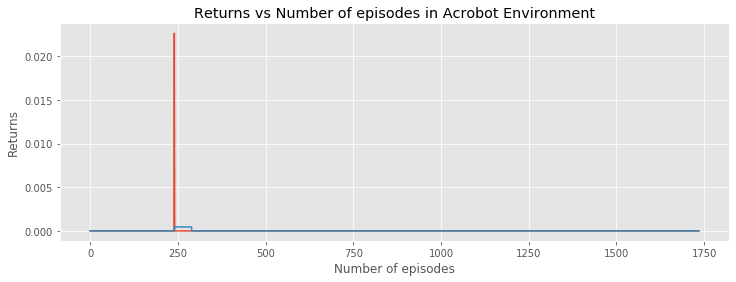

In [325]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_unlock_pickup_per)
plt.plot(rolling_average(returns_unlock_pickup_per,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Acrobot Environment')

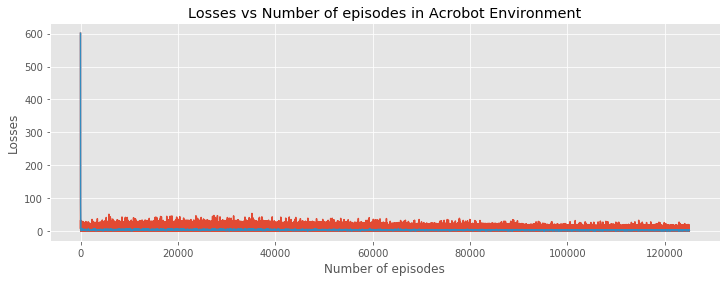

In [326]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_unlock_pickup_per)
plt.plot(rolling_average(losses_unlock_pickup_per,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Acrobot Environment')

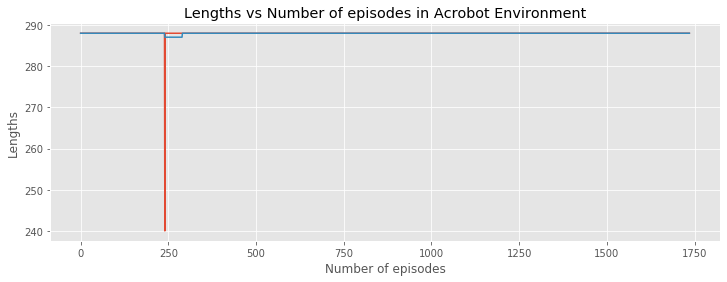

In [327]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_unlock_pickup_per)
plt.plot(rolling_average(lengths_unlock_pickup_per,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Acrobot Environment")

In [329]:
env = envs['blockedunlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 0.8 * num_steps)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_blocked_unlock_pickup_per, returns_blocked_unlock_pickup_per, lengths_blocked_unlock_pickup_per, losses_blocked_unlock_pickup_per = train_dqn_prioritized_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_blocked_unlock_pickup_per.items()}
torch.save(checkpoint, f'checkpoint_blockedunlockpickupper.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [330]:
filehandler = open("pickle/blocked_unlock_pickup_minigrid_dqn_returns_per.pkl", 'wb') 
pickle.dump(returns_blocked_unlock_pickup_per, filehandler)
filehandler.close()

filehandler2 = open("pickle/blocked_unlock_pickup_minigrid_dqn_losses_per.pkl", 'wb') 
pickle.dump(losses_blocked_unlock_pickup_per, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/blocked_unlock_pickup_minigrid_dqn_lengths_per.pkl", 'wb') 
pickle.dump(lengths_blocked_unlock_pickup_per, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

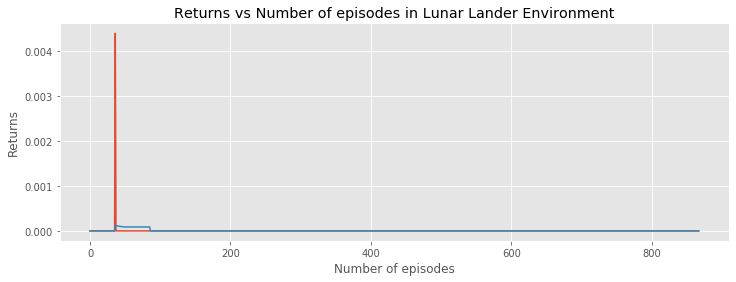

In [331]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_blocked_unlock_pickup_per)
plt.plot(rolling_average(returns_blocked_unlock_pickup_per,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

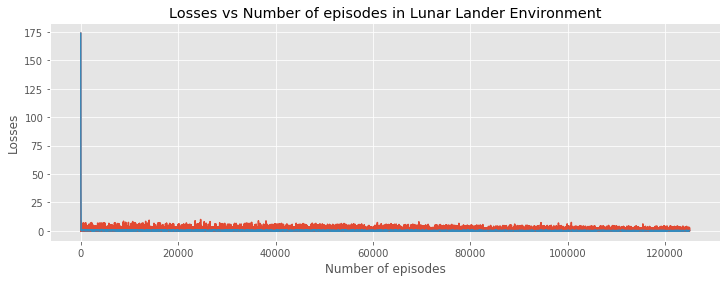

In [332]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_blocked_unlock_pickup_per)
plt.plot(rolling_average(losses_blocked_unlock_pickup_per,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

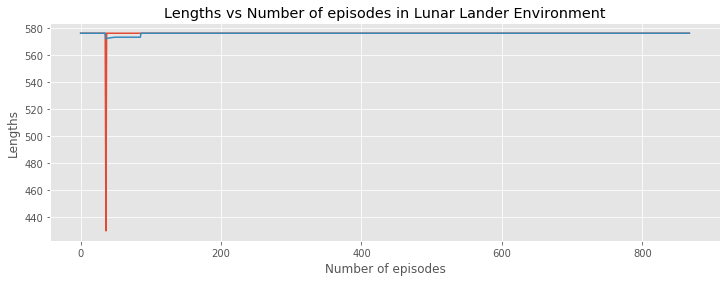

In [333]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_blocked_unlock_pickup_per)
plt.plot(rolling_average(lengths_blocked_unlock_pickup_per,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [334]:
env = envs['fourrooms']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)


alpha = 0.6
beta = 0.4

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_four_rooms_per, returns_four_rooms_per, lengths_four_rooms_per, losses_four_rooms_per = train_dqn_prioritized_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_four_rooms_per.items()}
torch.save(checkpoint, f'checkpoint_fourrooms.pt')

c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [335]:
filehandler = open("pickle/four_rooms_minigrid_dqn_returns_per.pkl", 'wb') 
pickle.dump(returns_four_rooms_per, filehandler)
filehandler.close()

filehandler2 = open("pickle/four_rooms_minigrid_dqn_losses_per.pkl", 'wb') 
pickle.dump(losses_four_rooms_per, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/four_rooms_minigrid_dqn_lengths_per.pkl", 'wb') 
pickle.dump(lengths_four_rooms_per, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

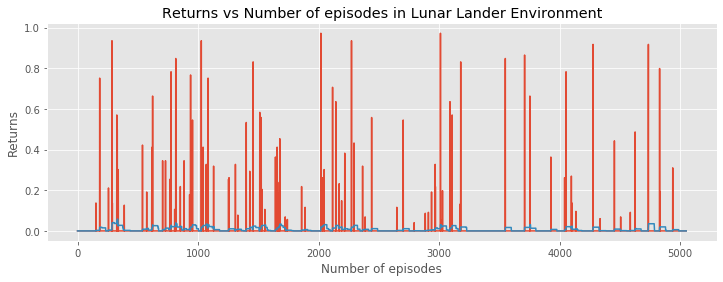

In [336]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_four_rooms_per)
plt.plot(rolling_average(returns_four_rooms_per,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

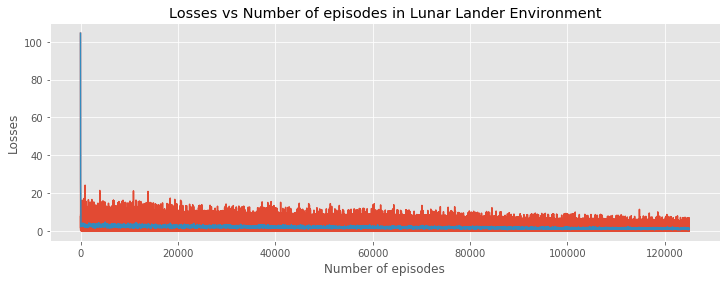

In [337]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_four_rooms_per)
plt.plot(rolling_average(losses_four_rooms_per,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

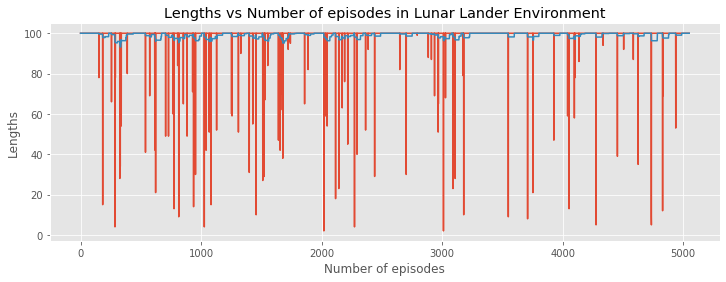

In [338]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_four_rooms_per)
plt.plot(rolling_average(lengths_four_rooms_per,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [339]:
class EpsilonReplayMemory:
    def __init__(self, max_size, state_size, exploration, batch_size, large):
        self.max_size = max_size
        self.state_size = state_size
        self.exploration = exploration
        self.steps = 0
        self.large = large

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))
        self.indices = torch.empty((max_size, 1))
        self.priorities = torch.zeros(max_size,dtype=torch.long)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0
       
        self.states_buffer = torch.empty((batch_size,self.state_size))
        self.actions_buffer = torch.empty((batch_size))
        self.rewards_buffer = torch.empty((batch_size))
        self.next_states_buffer = torch.empty((batch_size,self.state_size))
        self.dones_buffer = torch.empty((batch_size))
        self.indices_buffer = torch.empty((batch_size))
        self.priorities_buffer = torch.zeros(batch_size)

    def add(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        self.indices[self.idx][0] = torch.tensor(self.idx)
        max_priority = self.priorities.max(0)
        if(len(max_priority) == 0):
            self.priorities[self.idx] = torch.tensor(1)
        else:
            self.priorities[self.idx] = torch.tensor(max_priority[0])
       
        # DO NOT EDIT
        # circulate the pointer to the next position
       
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> PBatch:
        size = min(batch_size,self.size)
        evalue = self.exploration.value(self.steps)
       
        sample_indices = random.sample(range(1,self.size),(int)(size * (1-evalue)))
        if(evalue != 0):
            _,main_indices = self.priorities.topk((int)(evalue * size), largest = self.large)
            sample_indices.extend(main_indices)
        i = 0      
       
        for idx in sample_indices:
            self.states_buffer[i]= self.states[idx]
            self.actions_buffer[i] = self.actions[idx]
            self.rewards_buffer[i] = self.rewards[idx]
            self.next_states_buffer[i] = self.next_states[idx]
            self.dones_buffer[i] = self.dones[idx]
            self.indices_buffer[i] = self.indices[idx]
            i+=1

        batch = PBatch(states = self.states_buffer, actions = self.actions_buffer,
                       rewards = self.rewards_buffer, next_states = self.next_states_buffer, dones = self.dones_buffer,
                       indices = self.indices_buffer, priorities = None, weights = None)

        return batch

    def populate(self, env, num_steps):
        state = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            next_state = next_state
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = env.reset()
               
    def update(self, indices, priorities):
        count = 0
        for i in indices:
            self.priorities[i.long()] = priorities[count]
            count += 1
   
    def updateSteps(self, stepValue):
        self.steps = stepValue

In [340]:
def train_dqn_batch_epsilon(optimizer, memory, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    
    errors = torch.abs(target_values - values)    
    memory.update(batch.indices, errors)
    
    loss = F.mse_loss(values, target_values)
    
    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [404]:
def train_dqn_epsilon(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    alpha,
    beta
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = EpsilonReplayMemory(replay_size, state_size, exploration, batch_size, False)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        Q_array = dqn_model.forward(state)
        eps = exploration.value(t_total)
       
        if rnd.rand() < eps:
            num_actions = Q_array.shape[0]
            action = rnd.randint(num_actions)
        else:
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
           
        next_state, reward, done, _ = env.step(action)
        next_state = next_state
        memory.add(state, action, reward, next_state, done)
        state = next_state
       
        rewards.append(reward)
       
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
       
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch_epsilon(optimizer, memory, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
       
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
           
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            memory.updateSteps(i_episode)
            t_episode = 0
            state = env.reset()
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [410]:
env = envs['lunarlander']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_eps, returns_eps, lengths_eps, losses_eps = train_dqn_epsilon(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_eps.items()}
torch.save(checkpoint, f'checkpoint_epsilon_{env.spec.id}.pt')


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:76: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [411]:
filehandler = open("pickle/lunar_lander_dqn_returns_eps.pkl", 'wb') 
pickle.dump(returns_eps, filehandler)
filehandler.close()

filehandler2 = open("pickle/lunar_lander_dqn_losses_eps.pkl", 'wb') 
pickle.dump(losses_eps, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/lunar_lander_dqn_lengths_eps.pkl", 'wb') 
pickle.dump(lengths_eps, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

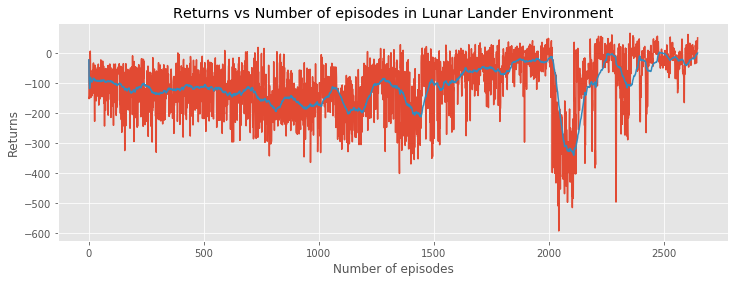

In [412]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_eps)
plt.plot(rolling_average(returns_eps,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

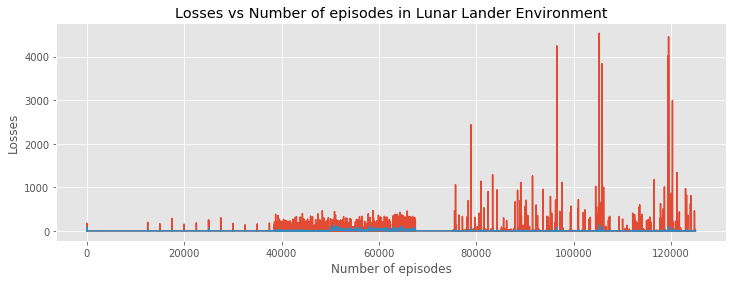

In [413]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_eps)
plt.plot(rolling_average(losses_eps,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

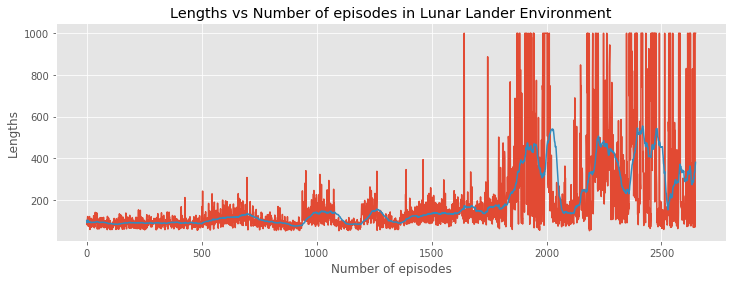

In [414]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_eps)
plt.plot(rolling_average(lengths_eps,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [ ]:
class EpsilonReplayMemoryMinigrid:
    def __init__(self, max_size, state_size, exploration, batch_size, large):
        self.max_size = max_size
        self.state_size = state_size
        self.exploration = exploration
        self.steps = 0
        self.large = large

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1))
        self.indices = torch.empty((max_size, 1))
        self.priorities = torch.zeros(max_size,dtype=torch.long)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0
       
        self.states_buffer = torch.empty((batch_size,self.state_size))
        self.actions_buffer = torch.empty((batch_size))
        self.rewards_buffer = torch.empty((batch_size))
        self.next_states_buffer = torch.empty((batch_size,self.state_size))
        self.dones_buffer = torch.empty((batch_size))
        self.indices_buffer = torch.empty((batch_size))
        self.priorities_buffer = torch.zeros(batch_size)

    def add(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.FloatTensor(state)
        self.actions[self.idx][0] = torch.tensor(action)
        self.rewards[self.idx][0] = torch.tensor(reward)
        self.next_states[self.idx] = torch.FloatTensor(next_state)
        self.dones[self.idx][0] = torch.tensor(done)
        self.indices[self.idx][0] = torch.tensor(self.idx)
        max_priority = self.priorities.max(0)
        if(len(max_priority) == 0):
            self.priorities[self.idx] = torch.tensor(1)
        else:
            self.priorities[self.idx] = torch.tensor(max_priority[0])
       
        # DO NOT EDIT
        # circulate the pointer to the next position
       
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> PBatch:
        size = min(batch_size,self.size)
        evalue = self.exploration.value(self.steps)
       
        sample_indices = random.sample(range(1,self.size),(int)(size * (1-evalue)))
        if(evalue != 0):
            _,main_indices = self.priorities.topk((int)(evalue * size), largest = self.large)
            sample_indices.extend(main_indices)
        i = 0      
       
        for idx in sample_indices:
            self.states_buffer[i]= self.states[idx]
            self.actions_buffer[i] = self.actions[idx]
            self.rewards_buffer[i] = self.rewards[idx]
            self.next_states_buffer[i] = self.next_states[idx]
            self.dones_buffer[i] = self.dones[idx]
            self.indices_buffer[i] = self.indices[idx]
            i+=1

        batch = PBatch(states = self.states_buffer, actions = self.actions_buffer,
                       rewards = self.rewards_buffer, next_states = self.next_states_buffer, dones = self.dones_buffer,
                       indices = self.indices_buffer, priorities = None, weights = None)

        return batch

    def populate(self, env, num_steps):
        state = flatten_image(env.reset())
        pbar = tqdm.trange(num_steps)
        for i in pbar:
            action = env.action_space.sample()
            next_state, rewards, done, info = env.step(action)
            next_state = flatten_image(next_state)
            self.add(state,action,rewards,next_state,done)
            state = next_state
            if(done):
                state = flatten_image(env.reset())
               
    def update(self, indices, priorities):
        count = 0
        for i in indices:
            self.priorities[i.long()] = priorities[count]
            count += 1
   
    def updateSteps(self, stepValue):
        self.steps = stepValue

In [ ]:
def train_dqn_batch_epsilon_minigrid(optimizer, memory, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    values_init = dqn_model.forward(batch.states)
    values = torch.gather(values_init,1,batch.actions.type(torch.LongTensor).unsqueeze(1))
    values = values.squeeze(1)
    
    rewards = batch.rewards
    next_states = batch.next_states
    dones = torch.tensor(batch.dones,dtype=torch.int)
    
    target_values = rewards + torch.mul((dqn_target.forward(next_states).max(1)[0] * gamma).float(), (1-dones).float())        
    target_values = target_values.detach()
    
    errors = torch.abs(target_values - values)    
    memory.update(batch.indices, errors)
    
    loss = F.mse_loss(values, target_values)
    
    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

In [355]:
def train_dqn_epsilon_minigrid(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    alpha,
    beta
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """

    # get the state_size from the environment
    state_size = flatten_image(env.reset()).shape[0]

    # initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())
#     optimizer = torch.optim.Adam(dqn_model.parameters)

    # initialize the replay memory and prepopulate it
    memory = EpsilonReplayMemoryMinigrid(replay_size, state_size, exploration, batch_size, True)
    memory.populate(env, replay_prepopulate_steps)

    # initiate lists to store returns, lengths and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = flatten_image(env.reset())  # initialize state of first episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        Q_array = dqn_model.forward(state.unsqueeze(0))
        eps = exploration.value(t_total)
       
        if rnd.rand() < eps:
            num_actions = Q_array.shape[1]
            action = rnd.randint(num_actions)
        else:
            actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
            action = rnd.choice(actions_maximal)
           
        next_state, reward, done, _ = env.step(action)
        next_state = flatten_image(next_state)
        memory.add(state, action, reward, next_state, done)
        state = next_state
       
        rewards.append(reward)
       
        # YOUR CODE HERE:  once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method!)
       
        if(t_total%4==0):
            batch = memory.sample(batch_size)
            losses.append(train_dqn_batch_epsilon_minigrid(optimizer, memory, batch, dqn_model, dqn_target, gamma))

        # YOUR CODE HERE:  once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods!)
       
        if(t_total%10000==0):
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            # YOUR CODE HERE:  anything you need to do at the end of an
            # episode, e.g. compute return G, store stuff, reset variables,
            # indices, lists, etc.
            G = 0
            for i in reversed(rewards):
                G = gamma * G + i
            returns.append(G)
            rewards = []
           
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )
            lengths.append(t_episode + 1)
            i_episode += 1
            memory.updateSteps(i_episode)
            t_episode = 0
            state = flatten_image(env.reset())
        else:
            # YOUR CODE HERE:  anything you need to do within an episode
            t_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [356]:
env = envs['unlockminigrid']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_unlock_eps, returns_unlock_eps, lengths_unlock_eps, losses_unlock_eps = train_dqn_epsilon_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_unlock_eps.items()}
torch.save(checkpoint, f'checkpoint_unlockeps.pt')

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:46<00:00, 1066.59it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [357]:
filehandler = open("pickle/unlock_minigrid_dqn_returns_eps.pkl", 'wb') 
pickle.dump(returns_unlock_eps, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_minigrid_dqn_losses_eps.pkl", 'wb') 
pickle.dump(losses_unlock_eps, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_minigrid_dqn_lengths_eps.pkl", 'wb') 
pickle.dump(lengths_unlock_eps, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Acrobot Environment')

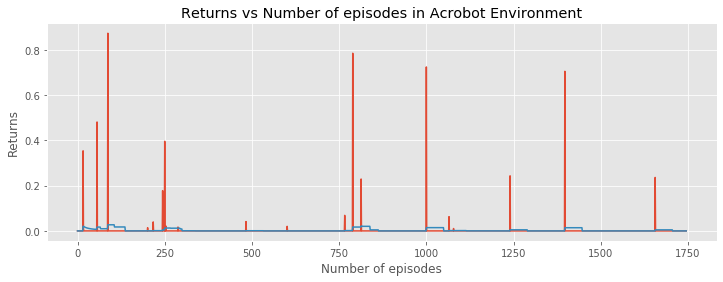

In [358]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_unlock_eps)
plt.plot(rolling_average(returns_unlock_eps,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Acrobot Environment')

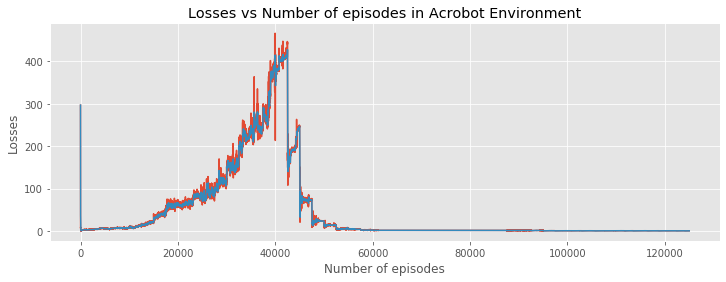

In [359]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_unlock_eps)
plt.plot(rolling_average(losses_unlock_eps,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Acrobot Environment')

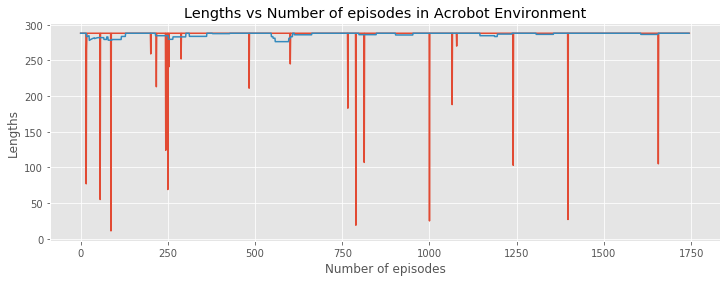

In [360]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_unlock_eps)
plt.plot(rolling_average(lengths_unlock_per,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Acrobot Environment")

In [361]:
env = envs['unlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
# num_steps = 300000
num_saves = 5 # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps*0.8)
# exploration = ExponentialSchedule(1.0, 0.05, 30000)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_unlock_pickup_eps, returns_unlock_pickup_eps, lengths_unlock_pickup_eps, losses_unlock_pickup_eps = train_dqn_epsilon_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_unlock_pickup_eps.items()}
torch.save(checkpoint, f'checkpoint_unlockpickupeps.pt')

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:55<00:00, 903.00it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [362]:
filehandler = open("pickle/unlock_pickup_minigrid_dqn_returns_pickup_eps.pkl", 'wb') 
pickle.dump(returns_unlock_pickup_eps, filehandler)
filehandler.close()

filehandler2 = open("pickle/unlock_pickup_minigrid_dqn_losses_pickup_eps.pkl", 'wb') 
pickle.dump(losses_unlock_pickup_eps, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/unlock_pickup_minigrid_dqn_lengths_pickup_eps.pkl", 'wb') 
pickle.dump(lengths_unlock_pickup_eps, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Acrobot Environment')

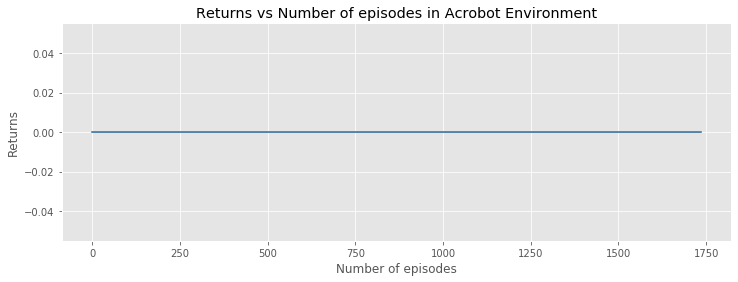

In [363]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_unlock_pickup_eps)
plt.plot(rolling_average(returns_unlock_pickup_eps,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Acrobot Environment')

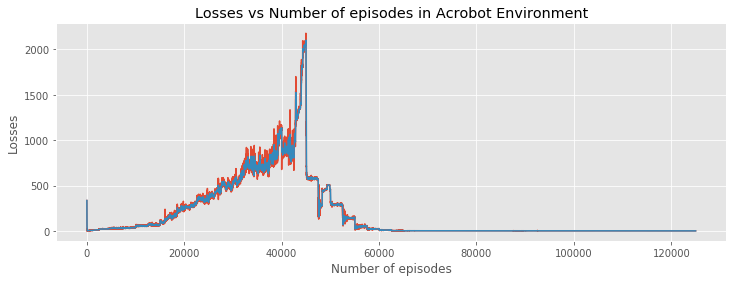

In [364]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_unlock_pickup_eps)
plt.plot(rolling_average(losses_unlock_pickup_eps,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Acrobot Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Acrobot Environment')

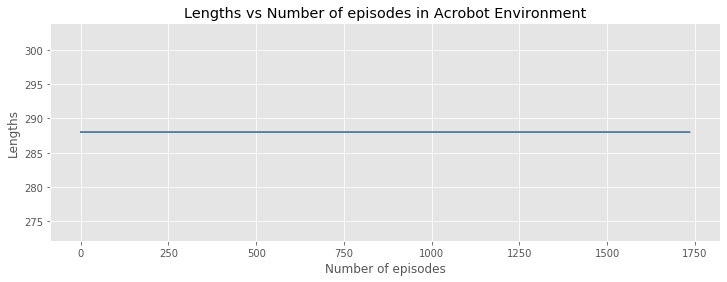

In [365]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_unlock_pickup_eps)
plt.plot(rolling_average(lengths_unlock_pickup_eps,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Acrobot Environment")

In [366]:
env = envs['blockedunlockpickup']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000


alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 0.8 * num_steps)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_blocked_unlock_pickup_eps, returns_blocked_unlock_pickup_eps, lengths_blocked_unlock_pickup_eps, losses_blocked_unlock_pickup_eps = train_dqn_epsilon_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_blocked_unlock_pickup_eps.items()}
torch.save(checkpoint, f'checkpoint_blockedunlockpickupeps.pt')

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:53<00:00, 938.17it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [367]:
filehandler = open("pickle/blocked_unlock_pickup_minigrid_dqn_returns_eps.pkl", 'wb') 
pickle.dump(returns_blocked_unlock_pickup_eps, filehandler)
filehandler.close()

filehandler2 = open("pickle/blocked_unlock_pickup_minigrid_dqn_losses_eps.pkl", 'wb') 
pickle.dump(losses_blocked_unlock_pickup_eps, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/blocked_unlock_pickup_minigrid_dqn_lengths_eps.pkl", 'wb') 
pickle.dump(lengths_blocked_unlock_pickup_eps, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

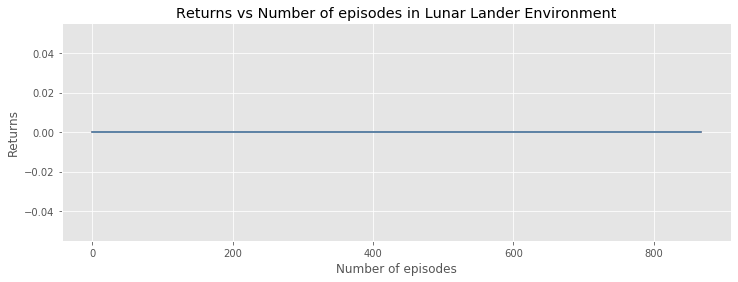

In [368]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_blocked_unlock_pickup_eps)
plt.plot(rolling_average(returns_blocked_unlock_pickup_eps,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

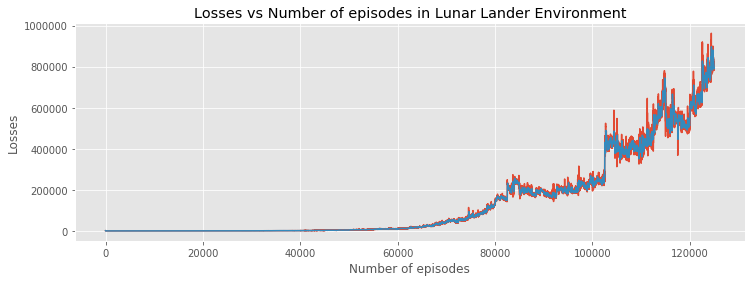

In [369]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_blocked_unlock_pickup_eps)
plt.plot(rolling_average(losses_blocked_unlock_pickup_eps,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

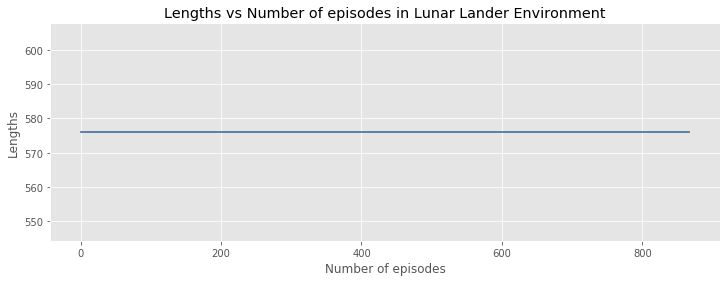

In [370]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_blocked_unlock_pickup_eps)
plt.plot(rolling_average(lengths_blocked_unlock_pickup_eps,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [371]:
env = envs['fourrooms']
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000


alpha = 0.6
beta = 0.4

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, num_steps * 0.8)

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models_four_rooms_eps, returns_four_rooms_eps, lengths_four_rooms_eps, losses_four_rooms_eps = train_dqn_epsilon_minigrid(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    alpha=alpha,
    beta=beta
)

# saving computed models to disk, so that we can load and visualize them later.
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models_four_rooms_per.items()}
torch.save(checkpoint, f'checkpoint_fourrooms.pt')

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 801.20it/s]
c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:71: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


c:\users\arn19\appdata\local\continuum\anaconda3\envs\gym\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [372]:
filehandler = open("pickle/four_rooms_minigrid_dqn_returns_eps.pkl", 'wb') 
pickle.dump(returns_four_rooms_eps, filehandler)
filehandler.close()

filehandler2 = open("pickle/four_rooms_minigrid_dqn_losses_eps.pkl", 'wb') 
pickle.dump(losses_four_rooms_eps, filehandler2)
filehandler2.close()

filehandler3 = open("pickle/four_rooms_minigrid_dqn_lengths_eps.pkl", 'wb') 
pickle.dump(lengths_four_rooms_eps, filehandler3)
filehandler3.close()

Text(0.5, 1.0, 'Returns vs Number of episodes in Lunar Lander Environment')

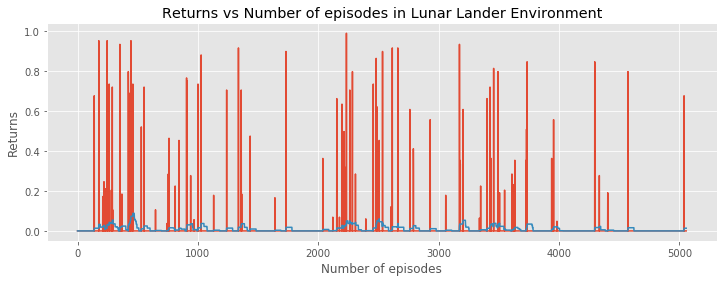

In [373]:
### YOUR PLOTTING CODE HERE
plt.plot(returns_four_rooms_eps)
plt.plot(rolling_average(returns_four_rooms_eps,window_size=50))
plt.ylabel("Returns")
plt.xlabel("Number of episodes")
plt.title("Returns vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Losses vs Number of episodes in Lunar Lander Environment')

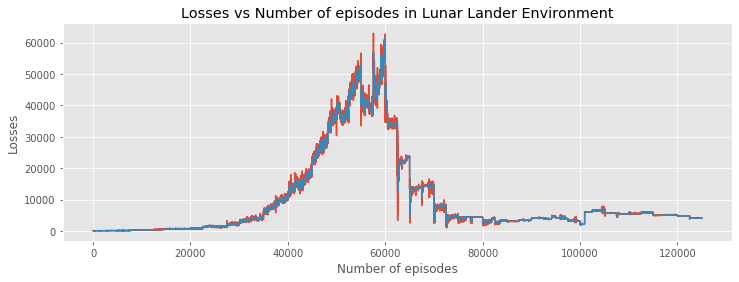

In [375]:
### YOUR PLOTTING CODE HERE
plt.plot(losses_four_rooms_eps)
plt.plot(rolling_average(losses_four_rooms_eps,window_size=50))
plt.ylabel("Losses")
plt.xlabel("Number of episodes")
plt.title("Losses vs Number of episodes in Lunar Lander Environment")

Text(0.5, 1.0, 'Lengths vs Number of episodes in Lunar Lander Environment')

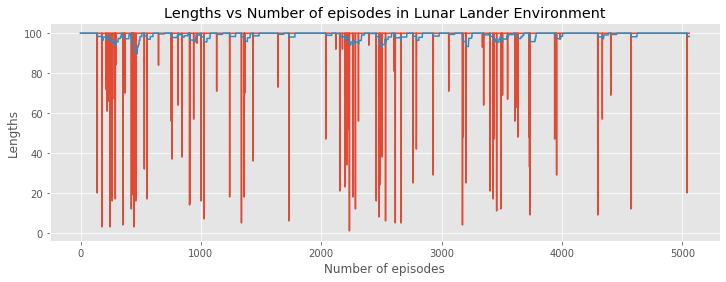

In [376]:
### YOUR PLOTTING CODE HERE
plt.plot(lengths_four_rooms_eps)
plt.plot(rolling_average(lengths_four_rooms_eps,window_size=50))
plt.ylabel("Lengths")
plt.xlabel("Number of episodes")
plt.title("Lengths vs Number of episodes in Lunar Lander Environment")

In [ ]:
buttons_all = []
for key_env, env in envs.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)